In [1]:
from brian2 import *
from matplotlib import pyplot as plt

%matplotlib inline
seed(12345)

In [2]:
start_scope()

################################################################################
# Model parameters
################################################################################
### General parameters
duration = 0.1*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step

N_sst = 4 # Number of SST neurons (inhibitory)
N_pv = 4  # Number of PV neurons (inhibitory)
N_cc = 4  # Number of CC neurons (excitatory)
N_cs = 4  # Number of CS neurons (excitatory)

### Neuron parameters
tau_S   = 16*ms  # 
tau_D   =  7*ms  #
tau_SST = 20*ms  #
tau_PV  = 10*ms  #
tau_E   =  5*ms  # Excitatory synaptic time constant
tau_I   = 10*ms  # Inhibitory synaptic time constant

C_S   = 370*pF
C_D   = 170*pF
C_SST = 100*pF
C_PV  = 100*pF

E_l  = -70*mV   # leak reversal potential
E_e  =   0*mV   # Excitatory synaptic reversal potential
E_i  = -80*mV   # Inhibitory synaptic reversal potential

V_t  = -50*mV   # spiking threashold
V_r  = E_l      # reset potential

c_d = 2600 * pA  # back-propagates somatic spikes to to the dendrites
g_s = 1300 * pA  # propagates dendritic regenerative activity to soma
g_d = 1200 * pA  # propagates dendritic regenerative activity to denderites

### Sigmoid function params
E_d = -38*mV  # position control of threshold
D_d =   6*mV  # sharpness control of threshold 

### Synapse parameters
w_e = 0.05*nS  # Excitatory synaptic conductance
w_i = 1.0*nS   # Inhibitory synaptic conductance


### External Input
g = 270*pA
M = 1.05 
I_ext_sst = [g for i in range(N_sst)]
I_ext_pv = [g for i in range(N_sst)]
I_ext_cs = [0 * pA for i in range(N_sst)]
I_ext_cc = [0 * pA for i in range(N_sst)]
# I_ext_sst = [g, g*M]    # external input SST
# I_ext_pv = [g, g*M] # external input PV
# I_ext_cs = [0*pA, 0*pA] # external input CS
# I_ext_cc = [0*pA, 0*pA] # external input CC

################################################################################

In [3]:
eqs_sst_inh = '''
    dv/dt = ((E_l-v)/tau_SST + I/C_SST) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens

    I = I_external + I_syn : amp
    I_syn = g_e*(E_e - v) + g_i*(E_i - v) : amp
    I_external : amp
'''

eqs_pv_inh = '''
    dv/dt = ((E_l-v)/tau_PV + I/C_PV) : volt (unless refractory)

    dg_e/dt = -g_e/tau_E : siemens
    dg_i/dt = -g_i/tau_I : siemens

    I = I_external + I_syn : amp
    I_syn = g_e*(E_e - v) + g_i*(E_i - v) : amp
    I_external : amp
'''

eqs_exc = '''
    dv_s/dt = ((E_l-v_s)/tau_S + (g_s*(1/(1+exp(-(v_d-E_d)/D_d))) + I_s)/C_S) : volt (unless refractory)

    dg_es/dt = -g_es/tau_E : siemens
    dg_is/dt = -g_is/tau_I : siemens

    I_s = I_external + I_syn_s : amp
    I_syn_s = g_es*(E_e - v_s) + g_is*(E_i - v_s) : amp
    I_external : amp

    dv_d/dt = ((E_l-v_d)/tau_D + (g_d*(1/(1+exp(-(v_d-E_d)/D_d))) + c_d*K + I_d)/C_D) : volt

    dg_ed/dt = -g_ed/tau_E : siemens
    dg_id/dt = -g_id/tau_I : siemens

    I_d = I_syn_d : amp
    I_syn_d = g_ed*(E_e - v_d) + g_id*(E_i - v_d) : amp
    K : 1
'''

In [4]:
# One CC neuron test
test_cc = NeuronGroup(1, model=eqs_exc, threshold='v_s > 50*mV',
                             reset='v_s = E_l', refractory=8.3 * ms, method='euler')
test_cc.set_states({'I_external': 0*pA})
test_cc.v_s = 'E_l + rand()*(V_t-E_l)'
test_cc.v_d = -70 * mV
test_cc.g_es = test_cc.g_ed = 'rand()*w_e'
test_cc.g_is = test_cc.g_id = 'rand()*w_i'
test_cc.K = 0

backprop_CC = Synapses(test_cc, test_cc, on_pre={'up': 'K += 1', 'down': 'K -=1'},
                           delay={'up': 0.5 * ms, 'down': 2 * ms}, name='backprop_CC')
backprop_CC.connect(condition='i==j')  # Connect all CC neurons to themselves


WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


In [5]:
spike_mon_cc = SpikeMonitor(test_cc)
state_mon_cc = StateMonitor(test_cc, ['v_s', 'v_d', 'g_es', 'g_is', 'g_ed', 'g_id'], record=0)

In [6]:
# ##############################################################################
# # Simulation run
# ##############################################################################

defaultclock.dt = sim_dt

run(duration, report='text')

Starting simulation at t=0. s for a duration of 100. ms
100. ms (100%) simulated in < 1s


Spike times CC: [] s


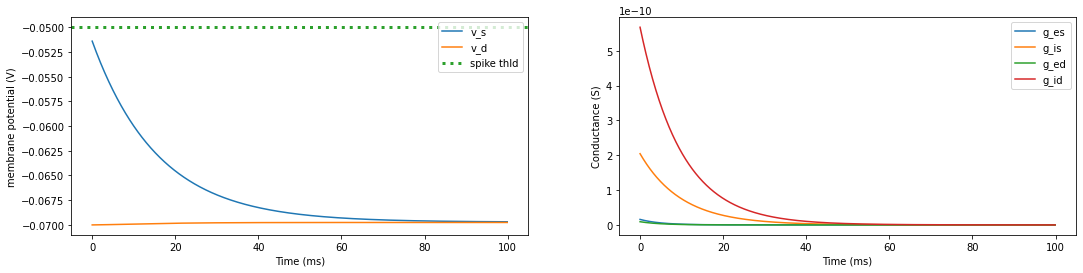

In [7]:
# CC Neurons

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_cc.t / ms, state_mon_cc.v_s[0], label='v_s')
plot(state_mon_cc.t / ms, state_mon_cc.v_d[0], label='v_d')
for (t, i) in zip(spike_mon_cc.t, spike_mon_cc.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3, label='spike thld')
xlabel('Time (ms)')
ylabel('membrane potential (V)')
legend(loc='upper right')

subplot(1, 2, 2)
plot(state_mon_cc.t / ms, state_mon_cc.g_es[0], label='g_es')
plot(state_mon_cc.t / ms, state_mon_cc.g_is[0], label='g_is')
plot(state_mon_cc.t / ms, state_mon_cc.g_ed[0], label='g_ed')
plot(state_mon_cc.t / ms, state_mon_cc.g_id[0], label='g_id')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times CC: %s" % spike_mon_cc.t[:])

In [ ]:
v_s = state_mon_cc.v_s[0][-1]
v_d = state_mon_cc.v_d[0][-1]
g_es = state_mon_cc.g_es[0][-1]
g_is = state_mon_cc.g_is[0][-1]

a = (E_l - v_s)/tau_S
b = g_s * (1/(1+exp(-(v_d-E_d)/D_d)))
c = 0 + g_es*(E_e - v_s) + g_is*(E_i - v_s)
d = (b + c)/C_S

print(f'(E_l-v_s)/tau_S: {a}')
print(f'g_s*f(v_d): {b}')
print(f'I_s: {c}')
print(f'(g_s*f(v_d) + I_s)/C_S: {d}')
print(f'dv_s/dt: {a+d}')
print(f'v_s: {v_s}')
print(f'v_d: {v_d}')

In [ ]:
# PV Neurons
test_pv = NeuronGroup(1, model=eqs_pv_inh, threshold='v > 50*mV',
                             reset='v = E_l', refractory=8.3 * ms, method='euler')
test_pv.set_states({'I_external': 0})
test_pv.v = 'E_l + rand()*(V_t-E_l)'
test_pv.g_e = 'rand()*w_e'
test_pv.g_i = 'rand()*w_i'

In [ ]:
spike_mon_pv = SpikeMonitor(test_pv)
state_mon_pv = StateMonitor(test_pv, ['v', 'g_e', 'g_i'], record=[0])

# ##############################################################################
# # Simulation run
# ##############################################################################

defaultclock.dt = sim_dt

run(duration, report='text')

In [ ]:
# PV Neurons plot

figure(figsize=(18, 4))
subplot(1, 2, 1)
plot(state_mon_pv.t / ms, state_mon_pv.v[0], label='v')
for (t, i) in zip(spike_mon_pv.t, spike_mon_pv.i):
    if i == 0:
        axvline(t / ms, ls='--', c='C1', lw=1)
axhline(V_t / mV / 1000, ls=':', c='C2', lw=3)
xlabel('Time (ms)')
ylabel('membrane potential (V)')

subplot(1, 2, 2)
plot(state_mon_pv.t / ms, state_mon_pv.g_e[0], label='g_e')
plot(state_mon_pv.t / ms, state_mon_pv.g_i[0], label='g_i')

xlabel('Time (ms)')
ylabel('Conductance (S)')
legend(loc='best')

print("Spike times PV: %s" % spike_mon_pv.t[:])